In [14]:
# Reference: https://www.tensorflow.org/versions/r1.1/get_started/mnist/beginners
# Reference: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html
# Reference: https://github.com/marcoancona/DeepExplain/blob/master/examples/mnist_tensorflow.ipynb
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf


# import "Skater" related functions
%matplotlib inline
from skater.util.image_ops import load_image, show_image, normalize, add_noise, flip_pixels, image_transformation
from skater.util.image_ops import in_between, greater_than, greater_than_or_equal, equal_to
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_relevance_visualizer import visualize

### Download the MNIST dataset

In [2]:
current_level = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
mnist = input_data.read_data_sets("/tmp/", one_hot=True)
tf.logging.set_verbosity(current_level)

Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


### Initialize TensorFlow session

In [3]:
sess = tf.Session()

### Initialize variables for the Network

In [4]:
# Parameters
learning_rate = 0.005
num_steps = 2000
batch_size = 128

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input as tensors
X = tf.placeholder("float", [None, num_input] , name="input")
Y = tf.placeholder("float", [None, num_classes], name="output")

# weights and biases for each Layer
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1], mean=0.0, stddev=0.05)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], mean=0.0, stddev=0.05)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes], mean=0.0, stddev=0.05))
}
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'b2': tf.Variable(tf.zeros([n_hidden_2])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

### Create a model

In [5]:
def model(x, act=tf.nn.relu): 
    layer_1 = act(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = act(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'], name="absolute_output")
    return out_layer

# Construct model
logits = model(X)

### Specify a loss function

In [6]:
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Define Evaluation

In [7]:
correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

### Train the model

In [8]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
sess.run(init)

for step in range(1, num_steps+1):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
    if step % 100 == 0 or step == 1:
        # Calculate batch loss and accuracy
        loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})
        print("Step {} Minibatch Loss= {:.4f} Training Accuracy= {:.3f}".format(step, loss, acc))

print("success")

Step 1 Minibatch Loss= 1.7514 Training Accuracy= 0.617
Step 100 Minibatch Loss= 0.2353 Training Accuracy= 0.922
Step 200 Minibatch Loss= 0.1427 Training Accuracy= 0.938
Step 300 Minibatch Loss= 0.1303 Training Accuracy= 0.953
Step 400 Minibatch Loss= 0.0643 Training Accuracy= 0.977
Step 500 Minibatch Loss= 0.0584 Training Accuracy= 0.984
Step 600 Minibatch Loss= 0.1042 Training Accuracy= 0.992
Step 700 Minibatch Loss= 0.0532 Training Accuracy= 0.984
Step 800 Minibatch Loss= 0.1079 Training Accuracy= 0.977
Step 900 Minibatch Loss= 0.0245 Training Accuracy= 0.992
Step 1000 Minibatch Loss= 0.0435 Training Accuracy= 0.977
Step 1100 Minibatch Loss= 0.0072 Training Accuracy= 1.000
Step 1200 Minibatch Loss= 0.0069 Training Accuracy= 1.000
Step 1300 Minibatch Loss= 0.0057 Training Accuracy= 1.000
Step 1400 Minibatch Loss= 0.0116 Training Accuracy= 1.000
Step 1500 Minibatch Loss= 0.0407 Training Accuracy= 0.992
Step 1600 Minibatch Loss= 0.0122 Training Accuracy= 1.000
Step 1700 Minibatch Loss= 

### Evaluate performance on Test dataset

In [9]:
# Calculate accuracy for MNIST test images
test_x = mnist.test.images
test_y = mnist.test.labels

print("Test accuracy:", sess.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Test accuracy: 0.9732


### Persist the model for future use

In [10]:
# Reference: https://stackoverflow.com/questions/33759623/tensorflow-how-to-save-restore-a-model
#init = tf.global_variables_initializer()#
#sess.run(init)

saver = tf.train.Saver()
saver.save(sess, './data/models/simple_mnist_mlp/simple_mnist_mlp', global_step=num_steps)

'./data/models/simple_mnist_mlp/simple_mnist_mlp-2000'

### Interpret with Skater

In [11]:
test_idx = 189
input_x_i = test_x[[test_idx]]
input_y_i = test_y[test_idx].reshape(1, 10)
with DeepInterpreter(session=sess) as di:
    # 1. Restore the persisted model
    # 2. Retrieve the input tensor from the restored model
    saver = tf.train.import_meta_graph('./data/models/simple_mnist_mlp/simple_mnist_mlp-2000.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./data/models/simple_mnist_mlp/'))
    graph = tf.get_default_graph()
    X = graph.get_tensor_by_name("input:0")
    Y = graph.get_tensor_by_name("output:0")
    target_tensor = model(X)
    y_class = tf.argmax(target_tensor, 1)

    xs = input_x_i
    ys = input_y_i
    print("X shape: {}".format(xs.shape))
    print("Y shape: {}".format(ys.shape))
    
    # Predictions
    eval_dict = {X: xs, Y: ys}
    predicted_class = sess.run(y_class, feed_dict=eval_dict)
    print("Predicted Class: {}".format(predicted_class))
    #relevance_scores = di.explain('elrp', target_tensor * ys, X, xs, use_case='image')
    relevance_scores = {
       'elrp': di.explain('elrp', target_tensor * ys, X, xs, use_case='image'),
        'integrated gradient': di.explain('ig', target_tensor * ys, X, xs, use_case='image'),
    }

INFO:tensorflow:Restoring parameters from ./data/models/simple_mnist_mlp/simple_mnist_mlp-2000


2018-04-29 05:28:50,233 - LRP - INFO - Epsilon value: 0.0001
2018-04-29 05:28:50,233 - BaseGradient - INFO - Executing operations ...
2018-04-29 05:28:50,291 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrated Gradient


X shape: (1, 784)
Y shape: (1, 10)
Predicted Class: [1]


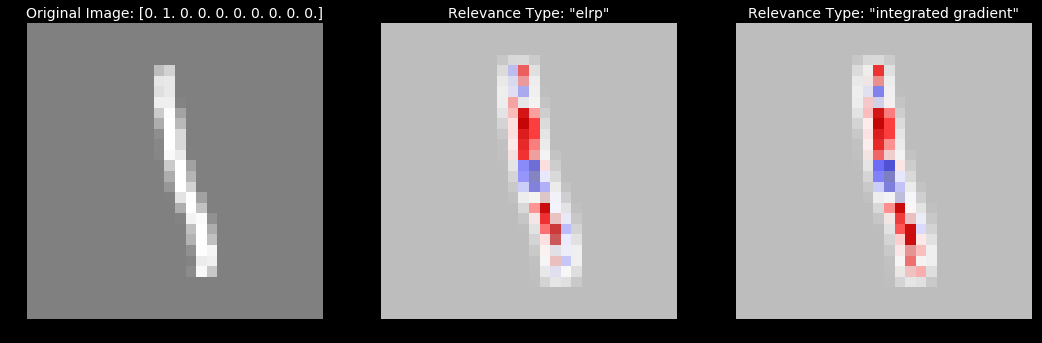

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
input_x = [input_x_i.reshape(28, 28)]
input_y = input_y_i

n_cols = int(len(relevance_scores)) + 1 # +1 to add a column for the original image
n_rows = len(input_x) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

# set the properties for text
font = {'family': 'avenir',
        'color':  'white',
        'weight': 'normal',
        'size': 14,
        }

fig.patch.set_facecolor('black')
for index, xi in enumerate(input_x):
    ax = axes.flatten()[index*n_cols]
    visualize(xi, cmap='gray', axis=axes[index], 
              alpha_edges=1.0, alpha_bgcolor=1).set_title('Original Image: {}'.format(input_y[index]), fontdict=font)
    for j, r_type in enumerate(relevance_scores):
        axj = axes.flatten()[index*n_cols+j+1]
        # Remember to reshape the relevance_score matrix as a 2-D array
        # Red: highlights positive relevance
        # Blue: highlights negative relevance
        visualize(relevance_scores[r_type][index].reshape(28, 28), original_input_img=xi, axis=axj, 
                  percentile=99,  alpha_edges=1.0, 
                  alpha_bgcolor=0.75).set_title('Relevance Type: "{}"'.format(r_type), fontdict=font)